In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW
import os, sys
sys.path.append(os.path.abspath('..'))
import json
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import load_data, sentiment_mapper

In [2]:
# Initial experimentation with shape configurations

x = torch.randn(16, 75, 768, requires_grad=True) # (batch_size, seq_len, hidden_dim)
print(x.shape)

x = x.unsqueeze(1) # (batch_size, num_channels, seq_len, hidden_dim)
print(x.shape)

l = nn.Conv2d(1, 10, kernel_size=(10, 768), stride=1, padding=0)
x = l(x)
print(x.shape)

m = nn.MaxPool2d(kernel_size=(66, 1))
x = m(x)
print(x.shape)

f = nn.Flatten()
x = f(x)
print(x.shape)



torch.Size([16, 75, 768])
torch.Size([16, 1, 75, 768])
torch.Size([16, 10, 66, 1])
torch.Size([16, 10, 1, 1])
torch.Size([16, 10])


In [3]:
class BERT_CNN(nn.Module):
    def __init__(self, bert_path, num_classes, filter_size, num_filters, seq_len=75, freeze_bert=False):
        super(BERT_CNN, self).__init__()
        self.num_classes = num_classes
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.bert = AutoModel.from_pretrained(bert_path).to(self.device)
        self.cnn = nn.Conv2d(1, num_filters, kernel_size=(filter_size, self.bert.config.hidden_size), stride=1, padding=0)
        self.max_pool = nn.MaxPool2d(kernel_size=(seq_len-filter_size+1, 1))
        self.fc = nn.Linear(num_filters, num_classes)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, tokenized, h=None, c=None):
        # batch_size = tokenized['input_ids'].size(0)
        outputs = self.bert(**tokenized)
        hidden_outputs, pooled_outputs = outputs[0], outputs[1]
        out = self.cnn(hidden_outputs.unsqueeze(1))
        out = F.relu(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1) # Flattening to (batch_size, num_filters)
        logits = self.fc(out)
        return logits

In [4]:
# PARAMS
bert_path = 'bert-base-cased'
num_classes = 4
filter_size = 8
num_filters = 64
freeze_bert = True
seq_len = 75
batch_size = 16
shuffle = True

In [5]:
mapper_path = "../models/sent2idx.json"

train_loader = load_data("../data/train_laptops_sc.json", batch_size=batch_size, shuffle=shuffle, mapper_path=mapper_path)
val_loader = load_data("../data/test_laptops_sc.json", batch_size=batch_size, shuffle=shuffle, mapper_path=mapper_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
tokenizer = AutoTokenizer.from_pretrained(bert_path)
model = BERT_CNN(bert_path, num_classes, filter_size, num_filters, seq_len, freeze_bert).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = AdamW(model.parameters(), lr=5e-5)

In [8]:
with torch.no_grad():
    for idx, sample in enumerate(train_loader):
        text = sample['text']
        aspect = sample['aspect']
        y = sample['polarity'].to(device)
        tokenized = tokenizer(text, aspect, padding="max_length", max_length=seq_len, truncation=True, return_tensors="pt").to(device)
        output = model(tokenized)
        print(output.shape)
        loss = criterion(output, y)
        print(loss)
        break

torch.Size([16, 4])
tensor(1.4892, device='cuda:0')


In [9]:
def start_table():
    print("-"*66)
    print(f"|{'EPOCH':^15}|{'BATCH':^15}|{'TRAIN LOSS':^16}|{'EVAL LOSS':^15}|")
    print("-"*66)

In [10]:
def plot_loss(loss, title, xlabel, ylabel):
    sns.set(style="darkgrid")
    sns.lineplot(x=np.arange(len(loss)), y=loss).set(title=title, xlabel=xlabel, ylabel=ylabel)
    # plt.show();

In [11]:
def compute_metrics(pred, tags):
    if len(pred.shape) == 2:
        pred = pred.argmax(axis=-1)
    accuracy = (pred == tags).mean()
    print(classification_report(tags, pred, target_names=["positive", "neutral", "negative", "conflict"]))
    return accuracy

In [12]:
def train_epoch(model, optimizer, criterion, train_loader, val_loader, device, epoch_num, print_every=50):
    total_loss = 0
    batch_losses = []
    eval_losses = []

    for idx, sample in enumerate(train_loader):
        model.train()

        text = sample['text']
        aspect = sample['aspect']
        y = sample['polarity'].to(device)

        tokenized = tokenizer(text, aspect, padding="max_length", max_length=seq_len, truncation=True, return_tensors="pt").to(device)

        optimizer.zero_grad()
        output = model(tokenized)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_losses.append(loss.item())

        if (idx+1) % print_every == 0:
            # print(f"EPOCH: {epoch_num} BATCH:{idx+1}/{len(train_loader)} LOSS: {loss.item()}")
            eval_loss = evaluate(model, criterion, val_loader, device)
            eval_losses.append(eval_loss)
            print(f"|{epoch_num:^15}|{idx+1:^15}|{loss.item():^16.4f}|{eval_loss:^15.4f}|")
    
#             plot_loss(batch_losses)

    epoch_loss =  total_loss / len(train_loader)
    print("-"*66 + "\n")
    return model, epoch_loss, batch_losses, eval_losses

In [13]:
def evaluate(model, criterion, test_loader, device):
    model.eval()

    total_loss = 0

    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            text = sample['text']
            aspect = sample['aspect']
            y = sample['polarity'].to(device)

            tokenized = tokenizer(text, aspect, padding="max_length", max_length=seq_len, truncation=True, return_tensors="pt").to(device)

            output = model(tokenized)
            loss = criterion(output, y)

            total_loss += loss.item()

    epoch_loss =  total_loss / len(test_loader)
    # print(f"\VAL LOSS: {epoch_loss}\n")
    return epoch_loss

In [14]:
def evaluate_complete(model, test_loader, device):
    model.eval()

    outputs = None
    y = None

    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            text = sample['text']
            aspect = sample['aspect']
            y_ = sample['polarity'].cpu().numpy()

            tokenized = tokenizer(text, aspect, padding="max_length", max_length=seq_len, truncation=True, return_tensors="pt").to(device)

            output = model(tokenized).cpu().numpy()

            # Concatenate to the outputs
            outputs = np.concatenate((outputs, output), axis=0) if outputs is not None else output
            y = np.concatenate((y, y_), axis=0) if y is not None else y_

    accuracy = compute_metrics(outputs, y)
    return accuracy

In [23]:
def predict_sample(text, aspect, model, tokenizer):
    model.eval()
    with torch.no_grad():
        tokenized = tokenizer(text, aspect, padding="max_length", max_length=seq_len, truncation=True, return_tensors="pt").to(device)
        output = model(tokenized)
        output = output.argmax(dim=-1).cpu()[0].item()
        
        mapper = json.load(open(mapper_path, "r"))
        reverse_mapper = {v: k for k, v in mapper.items()}

        sentiment = reverse_mapper[output]
        return sentiment

In [16]:
def train(model, optimizer, criterion, epochs, train_loader, val_loader, device, print_every=50, eval_every=50):
    epoch_losses = []
    batch_losses = []
    eval_losses = []

    for epoch in range(epochs):
        # print(f"[INFO] STARTING EPOCH {epoch+1}:\n")
        start_table()
        model, epoch_loss, batch_losses_, eval_losses = train_epoch(model, optimizer, criterion, train_loader, val_loader, device, epoch+1, print_every)

        epoch_losses.append(epoch_loss)
        batch_losses.extend(batch_losses_)
        eval_losses.extend(eval_losses)

        print(f"EPOCH: {epoch+1} AVG LOSS: {epoch_loss}\n")
        evaluate_complete(model, val_loader, device)

    plt.figure()  
    plot_loss(batch_losses, "Training Loss", "Step", "Loss")
    
    plt.figure()
    plot_loss(epoch_losses, "Training Loss", "Epoch", "Loss")
    
    return model, epoch_losses, batch_losses, eval_losses

In [17]:
epochs = 10
print_every = 20
eval_every = 20

------------------------------------------------------------------
|     EPOCH     |     BATCH     |   TRAIN LOSS   |   EVAL LOSS   |
------------------------------------------------------------------
|       1       |      20       |     1.1056     |    1.1085     |
|       1       |      40       |     0.9335     |    1.0680     |
|       1       |      60       |     1.0928     |    1.0598     |
|       1       |      80       |     0.9343     |    0.9567     |
|       1       |      100      |     0.7922     |    0.9290     |
|       1       |      120      |     0.7184     |    0.9137     |
|       1       |      140      |     0.7983     |    0.8993     |
------------------------------------------------------------------

EPOCH: 1 AVG LOSS: 1.0000619646665212



C:\Users\gupta\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    positive       0.77      0.84      0.81       332
     neutral       0.74      0.16      0.26       165
    negative       0.45      0.85      0.59       127
    conflict       0.00      0.00      0.00        16

    accuracy                           0.65       640
   macro avg       0.49      0.46      0.41       640
weighted avg       0.68      0.65      0.60       640

------------------------------------------------------------------
|     EPOCH     |     BATCH     |   TRAIN LOSS   |   EVAL LOSS   |
------------------------------------------------------------------
|       2       |      20       |     1.2116     |    0.8877     |
|       2       |      40       |     0.6621     |    0.8811     |
|       2       |      60       |     0.6981     |    0.8370     |
|       2       |      80       |     0.8110     |    0.8633     |
|       2       |      100      |     0.7990     |    0.8393     |
|       2       |      120   

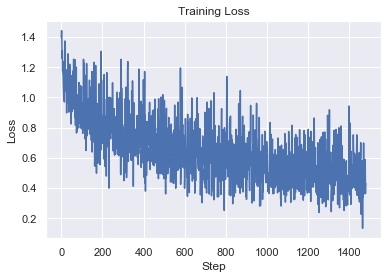

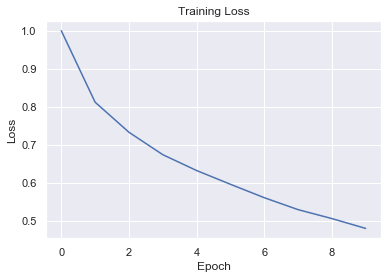

In [18]:
model, epoch_losses, batch_losses, eval_losses = train(model, 
                        optimizer, criterion, epochs, train_loader, val_loader, device, print_every, eval_every)

In [19]:
torch.save(model, "../models/BERT_CNN_frozen.pt")

In [36]:
text = "My laptop has decent speed but a horrible battery life!"
aspect = "battery life"

In [37]:
predict_sample(text, aspect, model, tokenizer)

'negative'